In [1]:
# R code to download R data
#library(CASdatasets)
# ***
#data(brvehins1a)
#write.csv(brvehins1a, "brvehins1a.csv", row.names=FALSE)
# *** repeat for brvehins1b, brvehins1c, brvehins1d, brvehins1e

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode
from sklearn.model_selection import train_test_split

%matplotlib inline 

C:\Python310\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


#### EDA for insurance data

In [2]:
dfData=pd.DataFrame()
folder='CASDatasets/'
for filename in ["brvehins1a.csv","brvehins1b.csv","brvehins1c.csv","brvehins1d.csv","brvehins1e.csv"]:
    dfTemp= pd.read_csv(folder+filename)[['Gender', 'DrivAge', 'VehYear', 'VehModel', 'VehGroup','Area', 'State',
        'ExposTotal','ClaimNbPartColl','ClaimNbTotColl','ClaimAmountPartColl', 'ClaimAmountTotColl']]
    dfTemp['ClaimNbColl']=dfTemp['ClaimNbPartColl']+dfTemp['ClaimNbTotColl']
    dfTemp['ClaimAmountColl']=dfTemp['ClaimAmountPartColl']+dfTemp['ClaimAmountTotColl']    
    dfTemp.drop(columns=['ClaimNbPartColl','ClaimNbTotColl','ClaimAmountPartColl', 'ClaimAmountTotColl'], inplace=True)
    dfData=pd.concat([dfData, dfTemp], axis=0, ignore_index=True)
    del dfTemp
print(dfData.shape)
# filter out NA
dfData.dropna(inplace=True)
print(dfData.shape)
# filter out zero exposures
mask= (dfData['ExposTotal']>0) #filter out the policies have 0 exposure count 
dfData=dfData[mask]
print(dfData.shape)
# filter out short-term policies
mask= (dfData['ExposTotal']>14/365) #filter out the policies have 0 exposure count 
dfData=dfData[mask]
print(dfData.shape)
# Filter out Gender=='Corporate' (no claim for the group)
mask= (dfData['Gender']!='Corporate') 
dfData=dfData[mask]
print(dfData.shape)

(1965355, 10)
(1548256, 10)
(1542392, 10)
(1509222, 10)
(1359584, 10)


In [3]:
dfData.rename(columns={'ExposTotal':'Expo', 'ClaimNbColl':'Cnt', 'ClaimAmountColl':'Amt'}, inplace=True)
dfData['Freq']=dfData['Cnt']/dfData['Expo']
dfData['Sev']=dfData['Amt']/dfData['Cnt']
dfData['LossCost']=dfData['Amt']/dfData['Expo']
dfData.describe()

,VehYear,Expo,Cnt,Amt,Freq,Sev,LossCost
count,1.359584e+06,1.359584e+06,1.359584e+06,1.359584e+06,1.359584e+06,179404.000000,1.359584e+06
mean,2.004929e+03,3.862130e+00,2.627201e-01,1.464307e+03,7.254643e-02,6438.071643,6.550812e+02
std,5.088419e+00,1.766298e+01,1.444499e+00,8.944253e+03,4.927349e-01,11684.839269,1.164347e+04
min,1.881000e+03,4.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00
25%,2.002000e+03,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1554.000000,0.000000e+00
50%,2.006000e+03,7.800000e-01,0.000000e+00,0.000000e+00,0.000000e+00,2966.000000,0.000000e+00
75%,2.009000e+03,2.290000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6021.000000,0.000000e+00
max,2.012000e+03,8.078440e+03,7.670000e+02,4.491086e+06,5.000000e+01,622483.000000,3.010725e+06


In [4]:
# number of unique levels in categorical variables
dfData.select_dtypes(include='object').nunique()

Gender         2
DrivAge        5
VehModel    4098
VehGroup     430
Area          40
State         27
dtype: int64

In [5]:
print("Total # exposures: {:.0f}".format(dfData['Expo'].sum()))
print("% policies with no claims: {:.0%}".format(
    (dfData['Cnt']==0).sum()/dfData.shape[0]))
print("% exposures with no claims: {:.0%}".format(
    (dfData.loc[dfData['Cnt']==0,'Expo']).sum()/dfData['Expo'].sum()))
print("frequency: {:.2%}".format(
    dfData['Cnt'].sum()/dfData['Expo'].sum()))
print("severity: {:.2f}".format(
    dfData['Amt'].sum()/dfData['Amt'].sum()))
print("% policies with exposure equal or less than 1: {:.0%}".format(
    ((dfData['Expo']<=1).sum()/dfData.shape[0])))


Total # exposures: 5250891
% policies with no claims: 87%
% exposures with no claims: 38%
frequency: 6.80%
severity: 1.00
% policies with exposure equal or less than 1: 57%


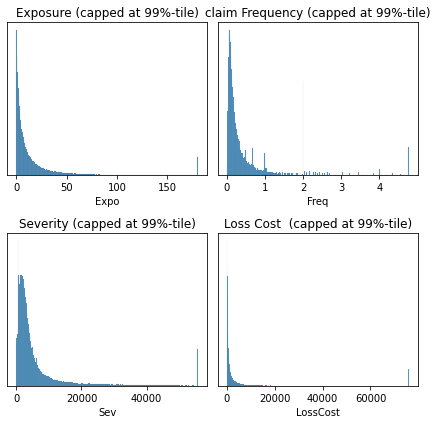

In [11]:
fig,axs=plt.subplots(2,2,figsize=(3*2,3*2),sharex=False, sharey=False)
mask=dfData['Cnt']>0
dfTemp=dfData[mask].reset_index().copy()

sns.histplot(x=dfTemp["Expo"].clip(0,dfTemp['Expo'].quantile(.99)), ax=axs[0,0]).set(
    title='Exposure (capped at 99%-tile)', yticklabels=[], ylabel='')
sns.histplot(x=dfTemp["Freq"].clip(0,dfTemp['Freq'].quantile(.99)), ax=axs[0,1]).set(
    title='claim Frequency (capped at 99%-tile)', yticklabels=[], ylabel='')
sns.histplot(x=dfTemp["Sev"].clip(0,dfTemp['Sev'].quantile(.99)), ax=axs[1,0]).set(
    title='Severity (capped at 99%-tile)', yticklabels=[], ylabel='')
sns.histplot(x=dfTemp["LossCost"].clip(0,dfTemp['LossCost'].quantile(.99)), ax=axs[1,1]).set(
    title='Loss Cost  (capped at 99%-tile)', yticklabels=[], ylabel='')
for ax in axs.reshape(-1):
    ax.tick_params(left=False)
plt.tight_layout()
plt.savefig('ppt/jupyter output/EDA.png', bbox_inches='tight')
plt.show();

In [25]:
# cap exposure at 1
dfData['Expo'].clip(0,1,inplace=True)
# restate claim count and claim amount with the updated exposure
dfData['Cnt'] = dfData['Expo'] * dfData['Freq']
dfData['Amt'] = dfData['Expo'] * dfData['LossCost']
dfData.describe()

,VehYear,Expo,Cnt,Amt,Freq,Sev,LossCost
count,1.359584e+06,1.359584e+06,1.359584e+06,1.359584e+06,1.359584e+06,179404.000000,1.359584e+06
mean,2.004929e+03,6.953985e-01,4.747834e-02,3.596739e+02,7.254643e-02,6438.071643,6.550812e+02
std,5.088419e+00,3.194584e-01,1.810536e-01,3.198180e+03,4.927349e-01,11684.839269,1.164347e+04
min,1.881000e+03,4.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00
25%,2.002000e+03,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1554.000000,0.000000e+00
50%,2.006000e+03,7.800000e-01,0.000000e+00,0.000000e+00,0.000000e+00,2966.000000,0.000000e+00
75%,2.009000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6021.000000,0.000000e+00
max,2.012000e+03,1.000000e+00,6.000000e+00,4.122404e+05,5.000000e+01,622483.000000,3.010725e+06


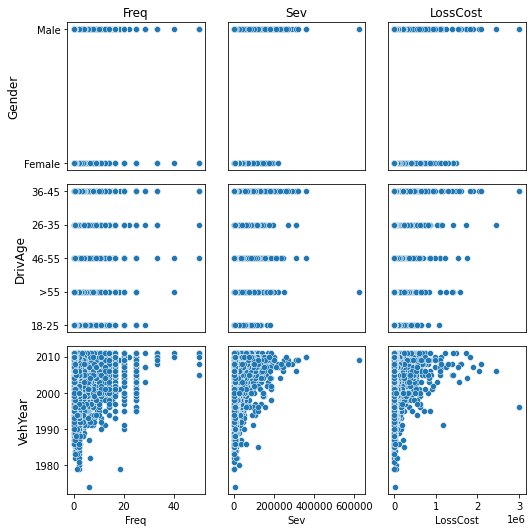

In [26]:
# plot the non-zero claims statistics by categorical variables
mask=dfData['Cnt']>0
dfTemp=dfData[mask].reset_index().copy()
rows=['Gender','DrivAge', 'VehYear']#,'VehGroup','State'
cols=['Freq','Sev','LossCost']

fig,axs=plt.subplots(len(rows),len(cols),figsize=(2.5*len(rows),2.5*len(cols)),sharex=False, sharey=False,)
fig.tight_layout()
for i, r in enumerate(rows):
    for j, c in enumerate(cols):
        sns.scatterplot(data=dfTemp, x=c, y=r, ax=axs[i,j])
        axs[0,j].set_title(c)
        axs[i,0].set_ylabel(r, rotation=90, size='large')
        if i<(len(rows)-1) :
            axs[i,j].axes.get_xaxis().set_visible(False)
        if j>0:
            axs[i,j].axes.get_yaxis().set_visible(False)
        if i>2:
            axs[i,0].set(yticklabels=[])
plt.tight_layout()
plt.show();

#### Merge Geometric Data

In [27]:
# Geometric data
# source: https://data.humdata.org/dataset/f5f0648e-f085-4c85-8242-26bf6c942f40/resource/2f26be26-a081-4557-8572-58545cd70e9f/download/bra_adm_ibge_2020_shp.zip
import unidecode
gdfState=gpd.read_file('data/bra_adm_ibge_2020_shp/bra_admbnda_adm1_ibge_2020.shp')
gdfState.loc[gdfState['ADM1_PCODE']=='BR32','ADM1_PT']="Esperito Santo"
gdfState['ADM1_PT']=gdfState['ADM1_PT'].apply(unidecode.unidecode)
# merge with original data
gdfState=gdfState[['ADM1_PT', 'geometry']].set_index('ADM1_PT').join(
    dfData.groupby('State', observed=True)[['Expo','Cnt','Amt']].sum(), how='left'
    ).reset_index().rename(columns={'ADM1_PT':'State'})
gdfState['Freq']=gdfState['Cnt']/gdfState['Expo']
gdfState['Sev']=gdfState['Amt']/gdfState['Cnt']
gdfState['LossCost']=gdfState['Amt']/gdfState['Expo']
gdfState.head()

,State,geometry,Expo,Cnt,Amt,Freq,Sev,LossCost
0,Acre,"MULTIPOLYGON (((-68.87747 -11.01987, -68.88027...",2837.89,301.775747,1.891087e+06,0.106338,6266.530667,666.370779
1,Alagoas,"POLYGON ((-35.46317 -8.82467, -35.46457 -8.828...",11860.11,857.277983,5.810007e+06,0.072282,6777.273618,489.878041
2,Amapa,"MULTIPOLYGON (((-50.46147 2.11133, -50.45627 2...",2010.88,217.049559,1.831919e+06,0.107938,8440.095927,911.003689
3,Amazonas,"MULTIPOLYGON (((-58.49367 -0.84197, -58.48917 ...",8031.44,759.392402,4.182107e+06,0.094552,5507.174930,520.716932
4,Bahia,"MULTIPOLYGON (((-38.70687 -17.96447, -38.70867...",27334.58,1612.526856,1.450262e+07,0.058992,8993.725190,530.559584


C:\Python310\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


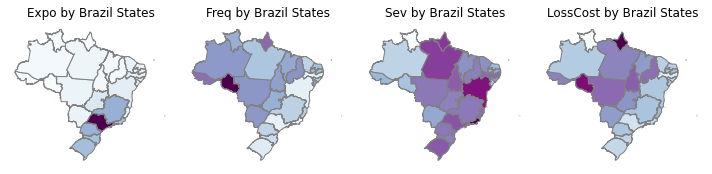

In [28]:
# plot claims statsitics by States on a map
cols=['Expo','Freq','Sev','LossCost']
fig, axs = plt.subplots(1,len(cols), figsize=(10,10*len(cols)), sharex=True, sharey=True)
for i, c in enumerate(cols):
    gdfState.plot(ax=axs[i], column=c, cmap='BuPu', edgecolor='gray').set(title=c + ' by Brazil States')
    axs[i].axis('off')
plt.tight_layout()
plt.show();

In [29]:
# pre-merge to meet credibility requirement
import libpysal
# credibility threshold based on the total number of exposures in a state
expo_threshold=2500         
small_state=[]
neig_state=[]

# create a weight object to identify contiguous States
w_rook = libpysal.weights.Rook.from_dataframe(gdfState)
gdfState['cls_0']=gdfState['State'].copy()
expo_by_cls = gdfState.groupby('cls_0', observed=True, as_index=False)['Expo'].sum()
smallest_cls=expo_by_cls.loc[expo_by_cls['Expo'].idxmin(), 'cls_0']
# test if the smallest states is below credibility thredhold
while expo_by_cls['Expo'].min()<expo_threshold:  
    smallest_state=gdfState.loc[gdfState['cls_0'] == smallest_cls,].index.values[0]
    small_state.append(smallest_state)
    neighbors = w_rook.neighbors[smallest_state]
    distance = gdfState.loc[neighbors,].distance(gdfState.loc[smallest_state,].geometry.centroid)
    closest_neig=distance.idxmin()
    neig_state.append(closest_neig)
    # combine the state with its closest neighbour
    gdfState.loc[smallest_state,'cls_0'] = gdfState.loc[closest_neig,'cls_0']
    display(gdfState.loc[[smallest_state,closest_neig],:])
    expo_by_cls = gdfState.groupby('cls_0', observed=True, as_index=False)['Expo'].sum()
    smallest_cls=expo_by_cls.loc[expo_by_cls['Expo'].idxmin(), 'cls_0']

C:\Python310\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 6.
  warnings.warn(message)


,State,geometry,Expo,Cnt,Amt,Freq,Sev,LossCost,cls_0
21,Rondonia,"MULTIPOLYGON (((-60.09197 -11.85667, -60.09377...",1443.67,204.628145,1.226838e+06,0.141742,5995.451720,849.805126,Mato Grosso
10,Mato Grosso,"MULTIPOLYGON (((-56.65037 -17.32567, -56.64427...",16006.44,1527.531867,1.132459e+07,0.095432,7413.652115,707.502097,Mato Grosso


,State,geometry,Expo,Cnt,Amt,Freq,Sev,LossCost,cls_0
22,Roraima,"POLYGON ((-60.19277 5.25133, -60.19557 5.24113...",1764.95,155.596717,6.339091e+05,0.088159,4074.051753,359.165459,Amazonas
3,Amazonas,"MULTIPOLYGON (((-58.49367 -0.84197, -58.48917 ...",8031.44,759.392402,4.182107e+06,0.094552,5507.174930,520.716932,Amazonas


,State,geometry,Expo,Cnt,Amt,Freq,Sev,LossCost,cls_0
2,Amapa,"MULTIPOLYGON (((-50.46147 2.11133, -50.45627 2...",2010.88,217.049559,1.831919e+06,0.107938,8440.095927,911.003689,Para
13,Para,"MULTIPOLYGON (((-46.43447 -1.01537, -46.43887 ...",13065.49,1035.880315,8.673553e+06,0.079284,8373.122339,663.852072,Para


In [33]:
gdfState.loc[small_state,]

,State,geometry,Expo,Cnt,Amt,Freq,Sev,LossCost,cls_0
21,Rondonia,"MULTIPOLYGON (((-60.09197 -11.85667, -60.09377...",1443.67,204.628145,1.226838e+06,0.141742,5995.451720,849.805126,Mato Grosso
22,Roraima,"POLYGON ((-60.19277 5.25133, -60.19557 5.24113...",1764.95,155.596717,6.339091e+05,0.088159,4074.051753,359.165459,Amazonas
2,Amapa,"MULTIPOLYGON (((-50.46147 2.11133, -50.45627 2...",2010.88,217.049559,1.831919e+06,0.107938,8440.095927,911.003689,Para


C:\Python310\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Python310\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Python310\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


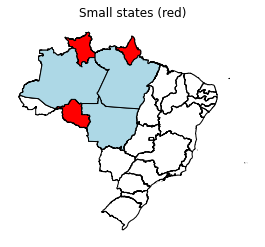

In [30]:
# plot the small states and their closest neighbours
fig, ax = plt.subplots()
gdfState.plot(ax=ax,color='None', edgecolor='black')
gdfState.loc[small_state,].plot(ax=ax,color='red', edgecolor='black')
gdfState.loc[neig_state,].plot(ax=ax,color='lightblue', edgecolor='black')
ax.set_title('Small states (red)')
ax.axis('off')
plt.show();

In [16]:
# add the pre-merged States (cls_0) into original data save
dfFull=dfData.merge(gdfState[['State','cls_0']], on='State', how='left')
# 70/30 split for train/test data
train,test = train_test_split(dfFull, test_size=0.3, random_state=42)

# save the data for next step
dfFull.to_csv('CASDatasets/clean_brvehins_pre_merge.csv')
train.to_csv('data/model_train.csv')
test.to_csv('data/model_test.csv')

In [18]:
pd.read_csv('data/model_train.csv', index_col=0).head()

,Gender,DrivAge,VehYear,VehModel,VehGroup,Area,State,Expo,Cnt,Amt,Freq,Sev,LossCost,cls_0
119891,Female,26-35,2006.0,Vw - Volkswagen - Fox City 1.0mi/ 1.0mi Total ...,Vw Volkswagen Fox 1.0,Piaui,Piaui,0.54,0.0,0.0,0.0,NaN,0.0,Piaui
584908,Male,>55,2007.0,Renault - Megane Grand Tour Dynam. Hi-flex 1.6...,Renault Megane,Grande Campinas,Sao Paulo,1.00,0.0,0.0,0.0,NaN,0.0,Sao Paulo
1125710,Female,>55,2004.0,Renault - Clio Dynamique 1.6 16v 110cv 3p,Renault Clio Acima De 1.0,Met. Porto Alegre e Caxias do Sul,Rio Grande do Sul,1.00,0.0,0.0,0.0,NaN,0.0,Rio Grande do Sul
1121310,Male,36-45,2008.0,Vw - Volkswagen - Spacefox 1.6 Total Flex 8v 4p,Vw Volkswagen Spacefox,Para,Para,1.00,0.0,0.0,0.0,NaN,0.0,Para
1207354,Male,>55,2006.0,Gm - Chevrolet - Zafira Elite 2.0 Mpfi Flexpow...,Gm Chevrolet Zafira,Grande Campinas,Sao Paulo,0.40,0.0,0.0,0.0,NaN,0.0,Sao Paulo
